# yo basic litt intro (from 231n) of Generative Adversarial Networks (GANs)

Many of the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Practice: building a MNIST-M GAN!



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle as pkl
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Now, please run python create_mnistm.py to create "mnistm_data.pkl"


In [3]:
#some UTILITY FUNCTIONS
def preprocess_img(x):
    return 2 * x - 1.0
  
def deprocess_img(x):
    return (x + 1.0) / 2.0

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def shuffle_aligned_list(data):
    """Shuffle arrays in a list by shuffling each array identically."""
    num = data[0].shape[0]
    p = np.random.permutation(num)
    return [d[p] for d in data]

def batch_generator(data, batch_size, shuffle=True):
    """Generate batches of data.
    
    Given a list of array-like objects, generate batches of a given
    size by yielding a list of array-like objects corresponding to the
    same slice of each input.
    """
    if shuffle:
        data = shuffle_aligned_list(data)

    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size >= len(data[0]):
            batch_count = 0

            if shuffle:
                data = shuffle_aligned_list(data)

        start = batch_count * batch_size
        end = start + batch_size
        batch_count += 1
        yield [d[start:end] for d in data]

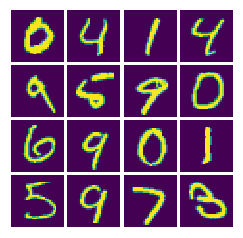

In [5]:
show_images(mnist.test.images[3:19])

#Code writing begins below

In [7]:
# Write a method to generate a uniform noise vector:
# use tf.random_uniform

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim)) * 2 - 1 # why * 2 - 1???

## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.layers` functions.

*Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.layers` to define the following architecture:

Recommended 
Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU (tf.nn.leaky_relu)
* Max Pool (tf.layers.max_pooling2d) 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU
* Max Pool 2x2, Stride 2
* Flatten (tf.layers.flatten)
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [9]:
# Write a discriminator model

def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        #write your discriminator model here
        #check my dimensionalities???
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, (-1, 28, 28, 1))
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[5,5], padding="valid", activation=tf.nn.leaky_relu) #28
        x = tf.layers.max_pooling2d(inputs=x, pool_size=[2,2], strides=2) #14
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=[5,5], padding="valid", activation=tf.nn.leaky_relu) #10
        x = tf.layers.max_pooling2d(inputs=x, pool_size=[2,2], strides=2) #5
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64, activation=tf.nn.leaky_relu, kernel_initializer=init)
        x = tf.layers.dense(x, 1, kernel_initializer=init)
        
        logits = x
        return logits

## Generator
Now to build a generator. Please use `tf.layers` for your implementation. You might find the documentation for [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) useful. The architecture is as follows.

Recommended Architecture:
* Fully connected with output size 1024 
* `ReLU` (tf.nn.relu)
* BatchNorm (tf.layers.batch_normalization)
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose) (tf.layers.conv2d_transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [10]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        #write your generator model here
        init = tf.contrib.layers.xavier_initializer()
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu, kernel_initializer=init)
        z = tf.layers.batch_normalization(z)
        z = tf.layers.dense(z, 7*7*128, activation=tf.nn.relu, kernel_initializer=init)
        z = tf.layers.batch_normalization(z)
        z = tf.reshape(z, (-1, 7, 7, 128))
        z = tf.layers.conv2d_transpose(z, 64, kernel_size=[4,4], padding="same", strides=2, activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z)
        z = tf.layers.conv2d_transpose(z, 1, kernel_size=[4,4], padding="same", strides=2, activation=tf.nn.tanh) #why tanh
        
        img = z
        
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [13]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
       
    dgz = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake))
    #what is sigmoid_cross_entropy???
    #what is logits and labels???
    #why tf.ones_like, and why input logits_fake (for size)???
    G_loss = tf.reduce_mean(dgz)
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=-logits_fake, labels=tf.ones_like(logits_fake)))
    
    return D_loss, G_loss

## The code block below is written out for you
Take the time to read through the code to understand it

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=.5)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=.5)

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [15]:
sess = tf.Session() 
init = tf.global_variables_initializer() 
sess.run(init)

0 Batch Loss: 0.4218505 2.760203


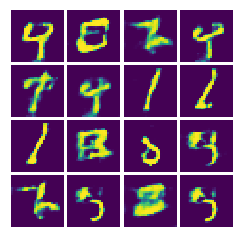


100 Batch Loss: 0.54412884 2.5162158
200 Batch Loss: 0.5601368 2.8730264
300 Batch Loss: 0.7033478 1.9459794
400 Batch Loss: 0.6801027 1.665191
500 Batch Loss: 0.5535401 2.0894802


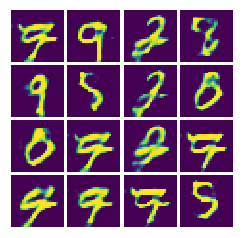


600 Batch Loss: 0.6094682 1.6785034
700 Batch Loss: 0.6143683 1.643018
800 Batch Loss: 0.48112696 2.1507812
900 Batch Loss: 0.6766573 2.0639825
1000 Batch Loss: 0.78608096 1.7958907


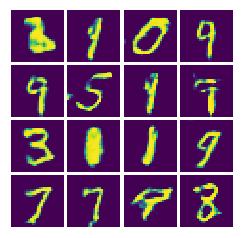


1100 Batch Loss: 0.5612482 2.5628905
1200 Batch Loss: 0.68245125 1.982549
1300 Batch Loss: 0.69832814 2.0334
1400 Batch Loss: 0.59564 2.0799048
1500 Batch Loss: 0.766384 3.554716


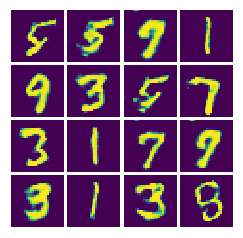


1600 Batch Loss: 0.7201481 2.4377234
1700 Batch Loss: 0.66363555 1.5905857
1800 Batch Loss: 0.666787 1.6307029
1900 Batch Loss: 0.6019264 1.8137937
2000 Batch Loss: 0.5582234 2.142206


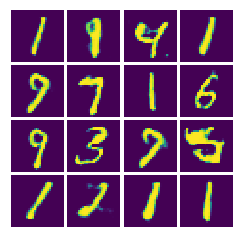


2100 Batch Loss: 0.5262693 2.5179722
2200 Batch Loss: 0.47514963 2.0223117
2300 Batch Loss: 0.65413463 2.0122342
2400 Batch Loss: 0.43469965 2.5335174
2500 Batch Loss: 0.540168 2.146865


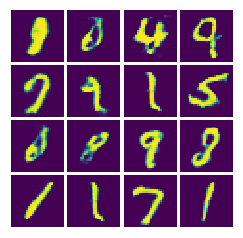


2600 Batch Loss: 0.56060237 2.5106573
2700 Batch Loss: 0.4246563 2.3054419
2800 Batch Loss: 0.5992081 2.3268633
2900 Batch Loss: 0.5224596 2.265087
3000 Batch Loss: 0.5388982 1.5782697


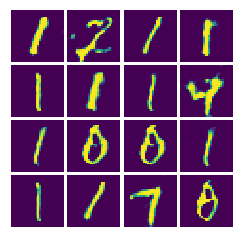


3100 Batch Loss: 0.4765052 2.0414262
3200 Batch Loss: 0.49179643 2.1788282
3300 Batch Loss: 0.8716936 3.0590792
3400 Batch Loss: 0.47943592 1.8028963
3500 Batch Loss: 0.4750911 2.3088512


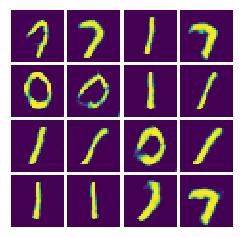


3600 Batch Loss: 0.47908884 2.6234813
3700 Batch Loss: 0.5823605 2.044677
3800 Batch Loss: 0.59010947 2.1614017
3900 Batch Loss: 0.46828374 2.041015
4000 Batch Loss: 0.44036177 2.4156218


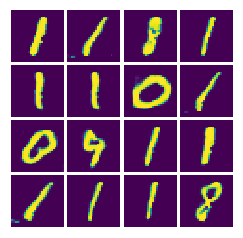


4100 Batch Loss: 0.52191716 2.2251244
4200 Batch Loss: 0.3657152 2.3308225
4300 Batch Loss: 0.54200006 2.0907612
4400 Batch Loss: 0.4497251 2.3243833
4500 Batch Loss: 0.5447507 2.7422156


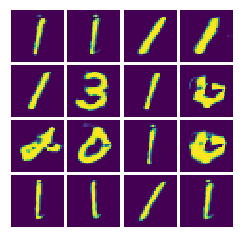


4600 Batch Loss: 0.43244568 1.9635864
4700 Batch Loss: 0.48746198 2.3315134
4800 Batch Loss: 0.42787302 2.4000976
4900 Batch Loss: 0.49127126 2.9049203
5000 Batch Loss: 0.37853217 2.3492482


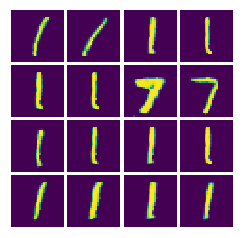

In [ ]:
# Now write your training loop

batch_size = 128 #your batch size
Gloss_plot = []
Dloss_plot = []
num_epochs = 5000 #10000
k = 1

mnist_batch = batch_generator([mnist.train.images, mnist.train.labels], batch_size)
for epoch in range(num_epochs + 1):
    batch_xs, _ = next(mnist_batch)
  
  #what do we need to write here
    _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: batch_xs})
  
    Dloss_plot.append(D_loss_curr) #appending the losses over the iterations
    for i in range(k):
        _, G_loss_curr = sess.run([G_train_step, G_loss])
        Gloss_plot.append(G_loss_curr)
        
    if epoch % 100 == 0:
        print(epoch, "Batch Loss:", D_loss_curr, G_loss_curr)
    if epoch % 500 == 0:
        samples = sess.run(G_sample) 
        fig = show_images(samples[:16])
        plt.show()
        print()


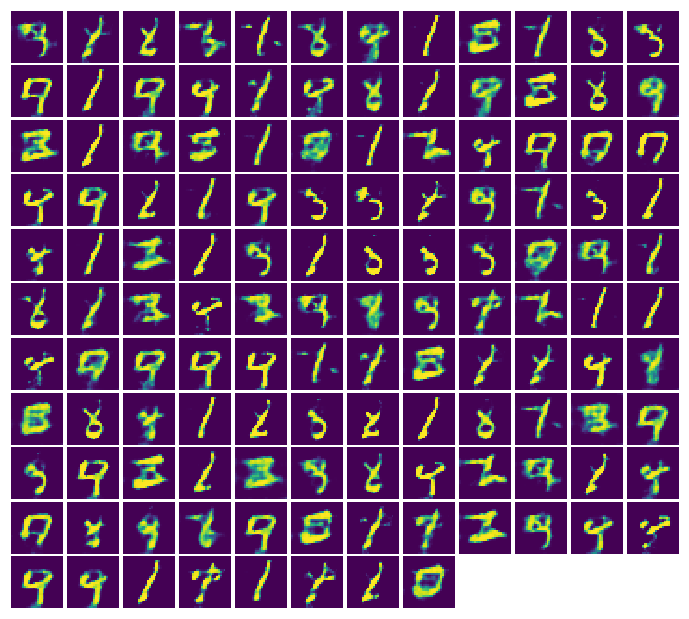

In [17]:
#see some pics
samples = sess.run(G_sample) 
fig = show_images(samples)
plt.show()

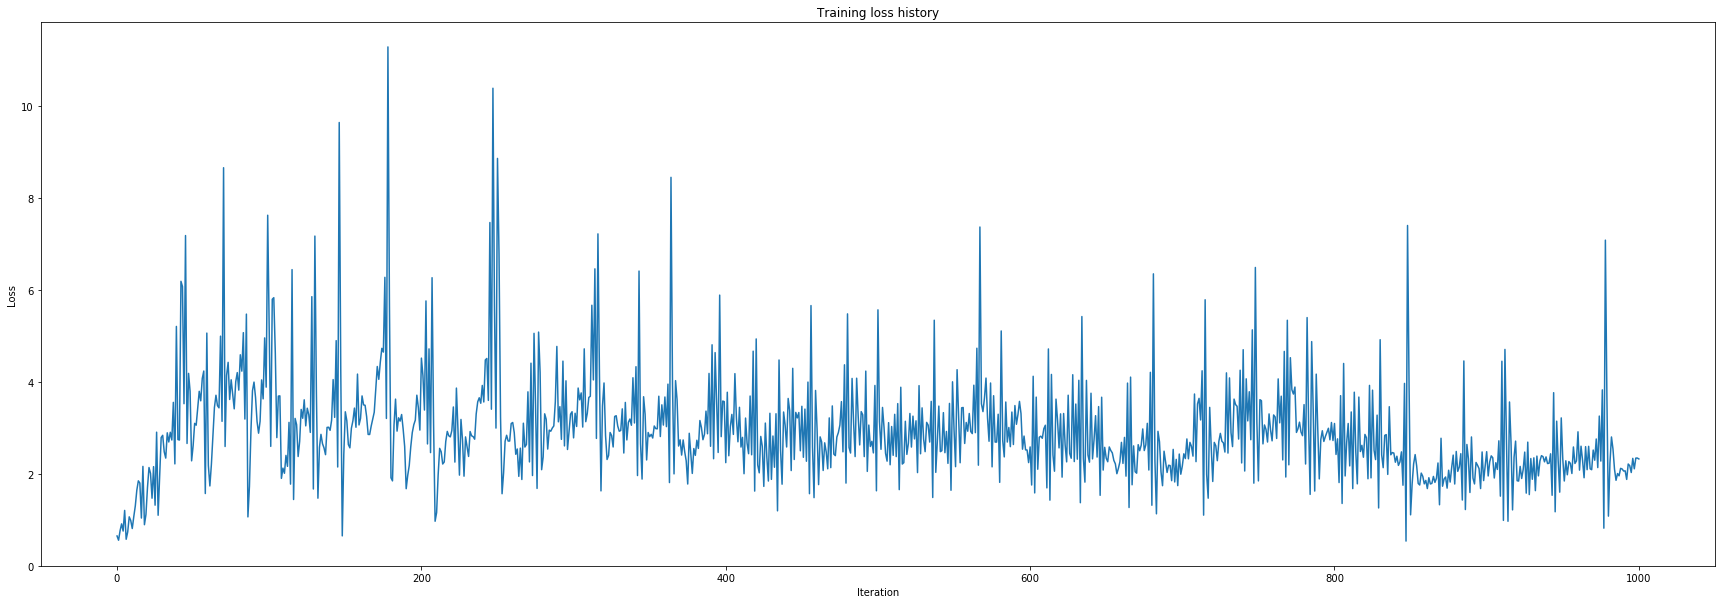

In [18]:
# Visualize loss plot
plt.plot(Gloss_plot)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.gcf().set_size_inches(30, 10)
plt.show()

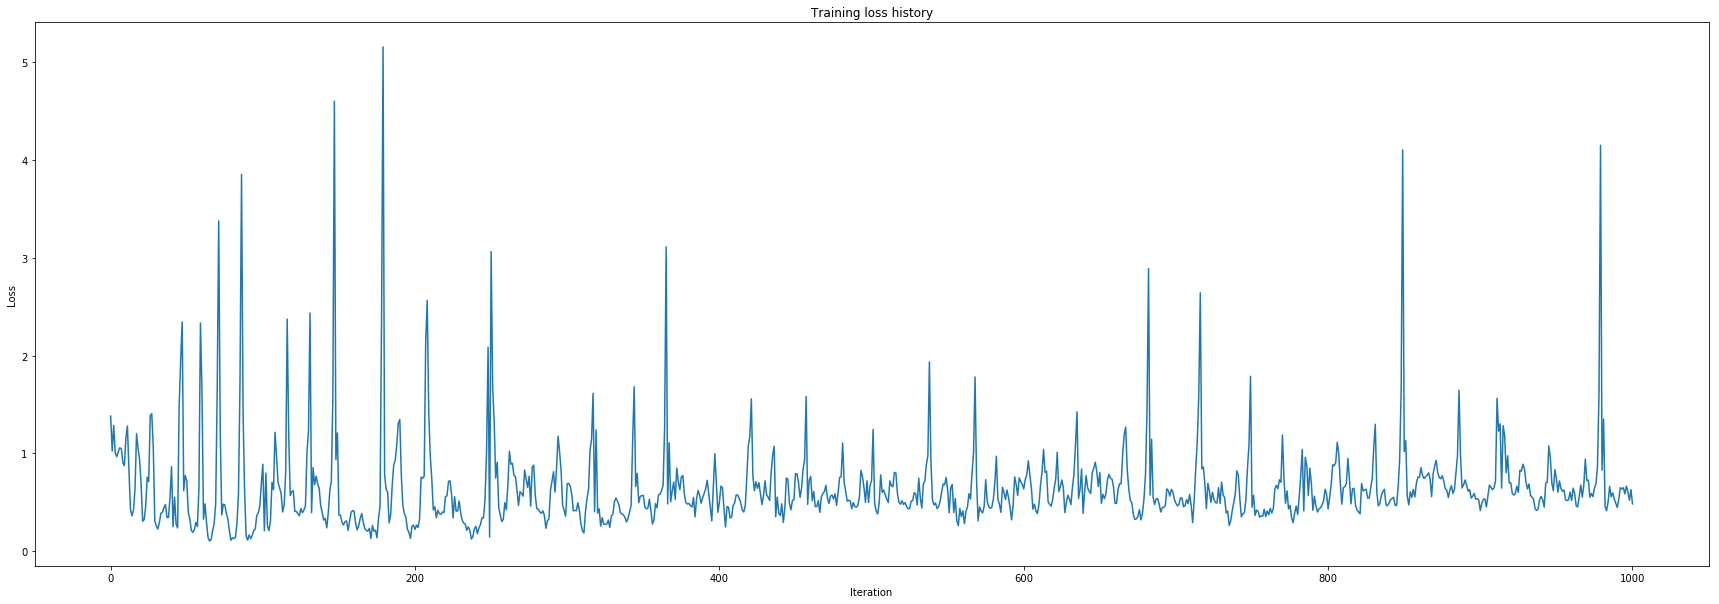

In [19]:
# Visualize loss plot
plt.plot(Dloss_plot)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.gcf().set_size_inches(30, 10)
plt.show()